# Вариационный автоэнкодер

Мотивация: нам никто вообще не гарантирует, что автоэнкодер работает, и что у него какое-то адекватное латентное пространство.

In [ ]:
!nvidia-smi

Fri Apr  2 12:49:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import datasets, transforms
import tqdm

In [ ]:
device = torch.device("cuda:0")

In [ ]:
!wget -O MNIST.tar.gz https://activeeon-public.s3.eu-west-2.amazonaws.com/datasets/MNIST.new.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-04-02 12:49:48--  https://activeeon-public.s3.eu-west-2.amazonaws.com/datasets/MNIST.new.tar.gz
Resolving activeeon-public.s3.eu-west-2.amazonaws.com (activeeon-public.s3.eu-west-2.amazonaws.com)... 52.95.148.18
Connecting to activeeon-public.s3.eu-west-2.amazonaws.com (activeeon-public.s3.eu-west-2.amazonaws.com)|52.95.148.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34812527 (33M) [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz        100%[===================>]  33.20M  22.6MB/s    in 1.5s    

2021-04-02 12:49:50 (22.6 MB/s) - ‘MNIST.tar.gz’ saved [34812527/34812527]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/train-images-idx3-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/processed/
MNIST/processed/test.pt
MNIST/processed/training.pt


In [ ]:
dataset = datasets.MNIST('./', train=True, download=False, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
class View(nn.Module):
    def __init__(self, shape):
        self.shape = shape
    
    def forward(self, x):
        return x.view(*shape)

In [ ]:
ngf = 64
ndf = 64
nc = 1
nz = 32

In [ ]:
class VAE(nn.Module):
    def __init__(self, nz):
        super(VAE, self).__init__()

        self.have_cuda = True
        self.nz = nz

        self.encoder = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ELU(inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.ELU(inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.ELU(inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.ELU(inplace=True),
        )

        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(1024, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ELU(inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ELU(inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU(inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Sigmoid(),
            # state size. (nc) x 64 x 64
        )

        self.fc1 = nn.Linear(1024, 512)
        self.fc21 = nn.Linear(512, nz)
        self.fc22 = nn.Linear(512, nz)

        self.fc3 = nn.Linear(nz, 512)
        self.fc4 = nn.Linear(512, 1024)

        self.elu = nn.ELU()

    def encode(self, x):
        conv = self.encoder(x);
        h1 = self.fc1(conv.view(-1, 1024))
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = self.elu(self.fc3(z))
        deconv_input = self.fc4(h3)
        deconv_input = deconv_input.view(-1,1024,1,1)
        return self.decoder(deconv_input)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if self.have_cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
model = VAE(nz).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
for epoch in range(20):
    train_loss = 0
    for idx, (data, _) in enumerate(loader):
        data = Variable(data)
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print('epoch %d, loss %.4f' % (epoch, train_loss / len(dataset)))

epoch 0, loss 92.2159
epoch 1, loss 92.0208
epoch 2, loss 91.8418
epoch 3, loss 91.7950
epoch 4, loss 91.6954
epoch 5, loss 91.6269
epoch 6, loss 91.4943
epoch 7, loss 91.4507
epoch 8, loss 91.3855
epoch 9, loss 91.3320
epoch 10, loss 91.2020
epoch 11, loss 91.1151
epoch 12, loss 91.1077
epoch 13, loss 91.0665
epoch 14, loss 90.9943


In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [ ]:
def get(x):
    return dataset[x][0].unsqueeze(0).cuda()  # измените формат, если хотите использовать свёртки

def imshow(img):
    pic = img.cpu().numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    latent = [model.reparametrize(*model.encode(get(k))) for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in np.linspace(0, 1, steps):
            c = a*(1-t)+b*t
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

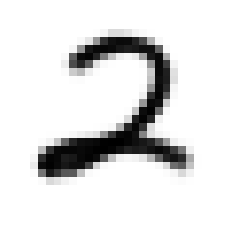

In [ ]:
morph(np.random.randint(0, len(dataset), 30), 20, 30)

Дополнительное чтение для ноулайферов: [Tutorial on Variational Autoencoders](https://arxiv.org/pdf/1606.05908.pdf).

# EM-алгоритм

Это задание было украдено с Deep Bayes 2018, а там оно в свою очередь было украдено у Чешского технического универсистета.

Данные скачать можно тут: https://goo.gl/6eD3BB

Немного помучайтесь с математикой, а когда надоест, посмотрите выводы формул здесь: https://github.com/bayesgroup/deepbayes-2018/blob/master/day1_em/seminar_em.pdf

Легенда такая: есть $K$ изображений, на которых изображен один из организаторов DeepBayes, но все из них были повреждены следующим процессом: есть фиксированное черно-белое изображение-фон $B$ (размера $W \times H$), в каждом изоражении лицо $F$ (размера $w \times H$) помещается в случайное место на фоне (для каждого изображения выбирается горизонтальный сдвиг $d_k$; априорные вероятности каждого сдвига обучаемы). Помимо этого, ко всем изображениям подмешивается белый шум (независимо ко всем пикселям) со средним 0 и дисперсией $s^2$.

Ваша задача — восстановить лицо. Формально, нужно найти такую матрицу, что правдоподобие сгенерированных изображений максимально.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir tmp
!unzip /content/drive/MyDrive/data_em.zip -d /tmp

Archive:  /content/drive/MyDrive/data_em.zip
  inflating: /tmp/data_em            


In [ ]:
w = 73  # ширина лица
X = np.load("/tmp/data_em")  # путь до данных

(-0.5, 199.5, 99.5, -0.5)

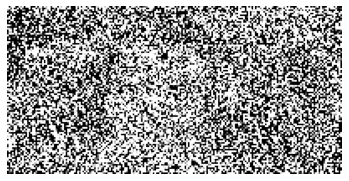

In [ ]:
plt.imshow(X[:, :, 0], cmap="Greys_r")
plt.axis("off")

Наша цель — найти лицо $F$ (матрица размера $H \times w$).

Также в процессе нам потребуется найти:
* $B$: фон  ($H \times W$)
* $s^2$: дисперсию шума (скаляр)
* $a$: априорные вероятности сдвигов ($W-w+1$ штук, должны суммироваться в единицу)
* $q(d)$: постериорные вероятности сдвигов для каждого изображения  (($W-w+1$) x $K$)

План реализации такой:
1. Вычислить $\log p(X  \mid d,\,F,\,B,\,s)$
2. E-шаг: посчитать $q(d)$
3. M-шаг: найти самые правдоподобные $F,\, B, \,s, \,a$
4. Соединить вместе E-шаг и M-шаг

In [ ]:
# EM-алгоритм может работать долго, и на больших данных его трудно тестировать
tH, tW, tw, tK = 2, 3, 1, 2
tX = np.arange(tH*tW*tK).reshape(tH, tW, tK).astype('float')
tF = np.arange(tH*tw).reshape(tH, tw)
tB = np.arange(tH*tW).reshape(tH, tW)
ts = 0.1
ta = np.arange(1, (tW-tw+1)+1)
ta = ta / ta.sum()
tq = np.arange(1, (tW-tw+1)*tK+1).reshape(tW-tw+1, tK)
tq = tq / tq.sum(axis=0)[np.newaxis, :]

## Вычисляем лог-вероятности

Для $k$-го изображения $X_k$ и сдвига $d_k$, его правдоподобие будет равно:

$$p(X_k  \mid d_k,\,F,\,B,\,s) = \prod_{ij}
    \begin{cases} 
    	\mathcal{N}(X_k[i,j]\mid F[i,\,j-d_k],\,s^2), 
    	& \text{if}\, (i,j)\in faceArea(d_k)\\
    	\mathcal{N}(X_k[i,j]\mid B[i,j],\,s^2), & \text{else}
    \end{cases}$$

Примечание:
* Не забудьте, что нам нужен логарифм всего этого.
* Желательно использовать не более одного цикла.

In [ ]:
def calculate_log_probability(X, F, B, s):
    """
    Calculates log p(X_k|d_k, F, B, s) for all images X_k in X and
    all possible face position d_k.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (H, w)
        Estimate of prankster's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.

    Returns
    -------
    ll : array, shape(W-w+1, K)
        ll[dw, k] - log-likelihood of observing image X_k given
        that the prankster's face F is located at position dw
    """
    H, W, K = X.shape
    w = F.shape[1]
    ll = np.zeros((W-w+1,K))
    for k in range(K):
        X_B = X[:,:,k] - B[:,:]
        XB = np.multiply(X_B, X_B)
        for dk in range(W-w+1):
            F_tmp = np.zeros((H, W))
            F_tmp[:, dk:dk+w] = F
            X_F = X[:, :, k] - F_tmp[:, :]
            XF = np.multiply(X_F, X_F)
            XB_ones = np.ones((H, W))
            XB_ones[:,dk:dk+w] = 0
            XF_ones = 1-XB_ones
            XB_tmp = np.multiply(XB, XB_ones)
            XF_tmp = np.multiply(XF, XF_ones)   
            summa = (np.sum(XB_tmp + XF_tmp)) * \
                (-1/(2*s**2)) - H*W*np.log(np.sqrt(2*np.pi)*s)
            ll[dk][k]=summa   
    return ll

In [ ]:
# run this cell to test your implementation
expected = np.array([[-3541.69812064, -5541.69812064],
       [-4541.69812064, -6741.69812064],
       [-6141.69812064, -8541.69812064]])
actual = calculate_log_probability(tX, tF, tB, ts)
assert np.allclose(actual, expected)
print('Works')

Works


## `сalculate_lower_bound`

$$\mathcal{L}(q, \,F, \,B,\, s,\, a) = \sum_k \biggl (\mathbb{E} _ {q( d_k)}\bigl ( \log p(  X_{k}  \mid {d}_{k} , \,F,\,B,\,s) + 
    \log p( d_k  \mid a)\bigr) - \mathbb{E} _ {q( d_k)} \log q( d_k)\biggr) $$
    
Примечания:
* Вы уже реализовали `calculate_log_probability` — используйте её. 
* Распределения $q(d_k)$ и $p( d_k  \mid a)$ дискретные. For example, $P(d_k=i \mid a) = a[i]$.
* Старайтесь не использовать циклы.

In [ ]:
def calculate_lower_bound(X, F, B, s, a, q):
    """
    Calculates the lower bound L(q, F, B, s, a) for 
    the marginal log likelihood.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (H, w)
        Estimate of prankster's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    a : array, shape (W-w+1)
        Estimate of prior on position of face in any image.
    q : array
        q[dw, k] - estimate of posterior 
                   of position dw
                   of prankster's face given image Xk

    Returns
    -------
    L : float
        The lower bound L(q, F, B, s, a) 
        for the marginal log likelihood.
    """
    K = X.shape[2]
    ll = calculate_log_probability(X, F, B, s)
    ll_exp = np.multiply(ll, q)
    q_exp = np.multiply(np.log(q), q)
    dk_exp = 0
    for k in range(K):
        dk_exp += np.multiply(np.log(a), q[:,k])
    L = np.sum(ll_exp)-np.sum(q_exp)+np.sum(dk_exp)
    
    return L

In [ ]:
expected = -12761.1875
actual = calculate_lower_bound(tX, tF, tB, ts, ta, tq)
assert np.allclose(actual, expected)
print('Works')

Works


## E-step

$$q(d_k) = p(d_k \mid X_k, \,F, \,B, \,s,\, a) = 
\frac {p(  X_{k}  \mid {d}_{k} , \,F,\,B,\,s)\, p(d_k \mid a)}
{\sum_{d'_k} p(  X_{k}  \mid d'_k , \,F,\,B,\,s) \,p(d'_k \mid a)}$$

Примечания:
* Используйте `calculate_log_probability`.
* Ради вычислительной стабильности, используйте операции с логарифмированными значениями и только в конце возводите в экспоненту. Также используйте этот трюк с софтмаксом:
$$\beta_i = \log{p_i(\dots)} \quad\rightarrow \quad
	\frac{e^{\beta_i}}{\sum_k e^{\beta_k}} = 
	\frac{e^{(\beta_i - \max_j \beta_j)}}{\sum_k e^{(\beta_k- \max_j \beta_j)}}$$
* Старайтесь не использовать циклы

In [ ]:
def run_e_step(X, F, B, s, a):
    """
    Given the current esitmate of the parameters, for each image Xk
    esitmates the probability p(d_k|X_k, F, B, s, a).

    Parameters
    ----------
    X : array, shape(H, W, K)
        K images of size H x W.
    F  : array_like, shape(H, w)
        Estimate of prankster's face.
    B : array shape(H, W)
        Estimate of background.
    s : float
        Eestimate of standard deviation of Gaussian noise.
    a : array, shape(W-w+1)
        Estimate of prior on face position in any image.

    Returns
    -------
    q : array
        shape (W-w+1, K)
        q[dw, k] - estimate of posterior of position dw
        of prankster's face given image Xk
    """
    ll = calculate_log_probability(X, F, B, s)
    K = X.shape[2]
    for k in range(K):
        max_ll = ll[:,k].max()
        ll[:,k] -= max_ll
        ll[:,k] = np.exp(ll[:,k])*a
        delitel = np.sum(ll[:,k])
        ll[:,k] /= delitel
    q = ll
    return q

In [ ]:
expected = np.array([[ 1.,  1.],
                   [ 0.,  0.],
                   [ 0.,  0.]])
actual = run_e_step(tX, tF, tB, ts, ta)
assert np.allclose(actual, expected)
print("OK")

OK


## M-step

$$a[j] = \frac{\sum_k q( d_k = j )}{\sum_{j'}  \sum_{k'} q( d_{k'} = j')}$$
$$F[i, m] = \frac 1 K  \sum_k \sum_{d_k} q(d_k)\, X^k[i,\, m+d_k]$$
$$B[i, j] = \frac {\sum_k \sum_{ d_k:\, (i, \,j) \,\not\in faceArea(d_k)} q(d_k)\, X^k[i, j]} 
	  	{\sum_k \sum_{d_k: \,(i, \,j)\, \not\in faceArea(d_k)} q(d_k)}$$
$$s^2 = \frac 1 {HWK}   \sum_k \sum_{d_k} q(d_k)
	  	\sum_{i,\, j}  (X^k[i, \,j] - M^{d_k}[i, \,j])^2$$

где $M^{d_k}[i, j]$ это изображение из фона, с наложенным на него лицом со сдвигом $d_k$.

Примечания:
* Порядок обновления параметров: $a$, $F$, $B$, $s$.
* Когда параметр обновляется, его __новое__ значение используется для обновления других параметров.
* Используйте не более 3 циклов (отдельных, не вложенных).

In [ ]:
def run_m_step(X, q, w):
    """
    Estimates F, B, s, a given esitmate of posteriors defined by q.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    q  :
        q[dw, k] - estimate of posterior of position dw
                   of prankster's face given image Xk
    w : int
        Face mask width.

    Returns
    -------
    F : array, shape (H, w)
        Estimate of prankster's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    a : array, shape (W-w+1)
        Estimate of prior on position of face in any image.
    """
    H, W, K = X.shape
    a = np.sum(q,axis=1) / np.sum(q)
    F = np.zeros((H,w))

    for k in range(K):
        for dk in range(W-w+1):
            F+=q[dk][k]*X[:,dk:dk+w,k]
    F = F / K
            
    B = np.zeros((H,W))
    delitel = np.zeros((H,W))
    for k in range(K):
        for dk in range(W-w+1):
            mask = np.ones((H,W))
            mask[:,dk:dk+w] = 0
            B += np.multiply(q[dk][k]*X[:,:,k],mask)
            delitel += q[dk][k]*mask
    delitel = 1/delitel
    B = B * delitel
    
    s = 0
    for k in range(K):
        for dk in range(W-w+1):
            F_B = np.zeros((H,W))
            F_B[:,dk:dk+w]=F
            mask = np.ones((H,W))
            mask[:,dk:dk+w] = 0
            Model = F_B + np.multiply(B,mask)
            temp = X[:,:,k]-Model[:,:]
            temp = np.multiply(temp,temp)
            temp = np.sum(temp)
            temp *= q[dk][k]
            s += temp
    s = np.sqrt(s /(H*W*K))          
    
    return F,B,s,a

In [ ]:
expected = [
    np.array([[ 3.27777778],
              [ 9.27777778]]),
    np.array([[  0.48387097, 2.5       ,   4.52941176],
              [  6.48387097, 8.5       ,  10.52941176]]),
    0.94868,
    np.array([ 0.13888889,  0.33333333,  0.52777778])
]
actual = run_m_step(tX, tq, tw)
for a, e in zip(actual, expected):
    assert np.allclose(a, e)

## Соединяем всё вместе

Инициализируйте чем-нибудь параметры, и повторяйте E- и M-шаги до сходимости. $\mathcal{L}(q, \,F, \,B, \,s, \,a)$ должна строго увеличиваться после каждой итерации.

In [ ]:
def run_EM(X, w, F=None, B=None, s=None, a=None, tolerance=0.001, max_iter=50):
    """
    Runs EM loop until the likelihood of observing X given current
    estimate of parameters is idempotent as defined by a fixed
    tolerance.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    w : int
        Face mask width.
    F : array, shape (H, w), optional
        Initial estimate of prankster's face.
    B : array, shape (H, W), optional
        Initial estimate of background.
    s : float, optional
        Initial estimate of standard deviation of Gaussian noise.
    a : array, shape (W-w+1), optional
        Initial estimate of prior on position of face in any image.
    tolerance : float, optional
        Parameter for stopping criterion.
    max_iter  : int, optional
        Maximum number of iterations.

    Returns
    -------
    F, B, s, a : trained parameters.
    LL : array, shape(number_of_iters + 2,)
        L(q, F, B, s, a) at initial guess, 
        after each EM iteration and after
        final estimate of posteriors;
        number_of_iters is actual number of iterations that was done.
    """
    H, W, N = X.shape
    if F is None:
        F = np.random.randint(0, 255, (H, w))
    if B is None:
        B = np.random.randint(0, 255, (H, W))
    if a is None:
        a = np.ones(W - w + 1)
        a /= np.sum(a)
    if s is None:
        s = np.random.rand()*pow(64,2)
    
    LL = [-50000]
    for i in range(max_iter):
        q = run_e_step(X,F,B,s,a)
        F,B,s,a = run_m_step(X,q,w)
        LL.append(calculate_lower_bound(X,F,B,s,a,q))
        if LL[-1]-LL[-2] < tolerance :
            break
    LL = np.array(LL)
    return F,B,s,a,LL

In [ ]:
res = run_EM(tX, tw, max_iter=3)
LL = res[-1]
assert np.alltrue(LL[1:] - LL[:-1] > 0)

## Так кто же на фотке?

In [ ]:
def show(F, i=1, n=1):
    plt.subplot(1, n, i)
    plt.imshow(F, cmap="Greys_r")
    plt.axis("off")

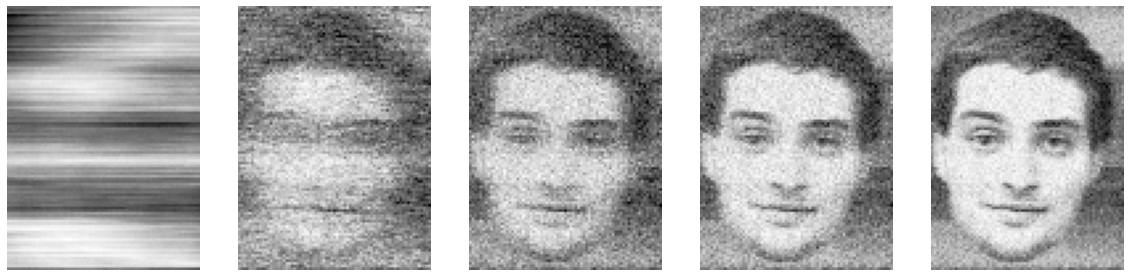

In [ ]:
F, B, s, a = [None] * 4
LL = []
lens = [50, 100, 300, 500, 1000]
iters = [5, 1, 1, 1, 1]
plt.figure(figsize=(20, 5))
for i, (l, it) in enumerate(zip(lens, iters)):
    F, B, s, a, _ = run_EM(X[:, :, :l], w, F, B, s, a, max_iter=it)
    show(F, i+1, 5)